Train FFNN model on any type of data, with or without linear preprocessing.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./fdnn_balatsoukas') # for balatsoukas plot func

import scipy.io as sio
import numpy as np
import fullduplex as fd
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle
from models import FFNN_model

from config import *

### Script Config

In [2]:
DATA_TYPE = 'W' # R/H/W
LIN_PREPROCESSING = True

CHANNEL_LEN = 13
TRAINING_RATIO = 0.9

EXPORT_RESULTS = True
PATH_EXPORT_RESULTS = 'comparison_results/2025_05_08/'

In [3]:
# This line disables the use of the GPU for training. The dataset is not large enough to get
# significant gains from GPU training and, in fact, sometimes training can even be slower on
# the GPU than on the CPU. Comment out to enable GPU use.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Define system parameters
params = {
		'samplingFreqMHz': 20,	# Sampling frequency, required for correct scaling of PSD
		'hSILen': CHANNEL_LEN,			# Self-interference channel length
		'pamaxordercanc': 7,	# Maximum PA non-linearity order
		'trainingRatio': TRAINING_RATIO,	# Ratio of total samples to use for training
		'dataOffset': 14,		# Data offset to take transmitter-receiver misalignment into account
		'nHidden': 17,			# Number of hidden layers in NN
		'nEpochs': 50,			# Number of training epochs for NN training
		'learningRate': 0.004,	# Learning rate for NN training
		'batchSize': 32,		# Batch size for NN training
		}


### Load Data

In [4]:
if DATA_TYPE == 'R':

    x, y, noise, measuredNoisePower = fd.loadData(PATH_DATA_REAL, params)

elif DATA_TYPE == 'H':

    matlabVariables = sio.loadmat(PATH_DATA_SYNTH_HAMMERSTEIN+'/train/fileID0.mat')
    x = np.squeeze(matlabVariables['sig_s'])
    y = np.squeeze(matlabVariables['sig_yH'])
    noise = np.squeeze(np.squeeze(matlabVariables['sig_yH']) - np.squeeze(matlabVariables['sig_x']))

elif DATA_TYPE == 'W':

    matlabVariables = sio.loadmat(PATH_DATA_SYNTH_WIENER+'/train/fileID0.mat')
    x = np.squeeze(matlabVariables['sig_z'])
    y = np.squeeze(matlabVariables['sig_yW'])
    noise = np.squeeze(np.squeeze(matlabVariables['sig_yH']) - np.squeeze(matlabVariables['sig_x']))

else:
    raise ValueError('DATA_TYPE must be either "R", "H", or "W".')

# remove mean
y = y - np.mean(y)

# Split into training and test sets
trainingSamples = int(np.floor(x.size*params['trainingRatio']))
x_train = x[0:trainingSamples]
y_train = y[0:trainingSamples]
x_test = x[trainingSamples:]
y_test = y[trainingSamples:]

y_test_orig = np.copy(y_test) # for later eval, untouched by lin. preproc.

/home/nknaepper/miniconda3/envs/enzner_env/lib/python3.7/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


#### Optional Linear Preprocessing

In [5]:
if LIN_PREPROCESSING:
    
    # Train-data
    hLin = fd.SIestimationLinear(x_train, y_train, params)
    y_train_lin = fd.SIcancellationLinear(x_train, hLin, params)
    y_train = y_train - y_train_lin

    # Test-data
    y_test_lin = fd.SIcancellationLinear(x_test, hLin, params)
    y_test = y_test - y_test_lin
    

./fdnn_balatsoukas/fullduplex.py:110: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, y[chanLen:])[0]


#### Target normalization (regardless of whether lin. preproc. was applied)

In [6]:
yVar = np.var(y_train)
y_train = y_train/np.sqrt(yVar)
y_test = y_test/np.sqrt(yVar)

### Prepare Model Input

In [7]:
# Train-data
x_train_real = np.reshape(np.array([x_train[i:i+CHANNEL_LEN].real for i in range(x_train.size-CHANNEL_LEN+1)]), (x_train.size-CHANNEL_LEN+1, CHANNEL_LEN))
x_train_imag = np.reshape(np.array([x_train[i:i+CHANNEL_LEN].imag for i in range(x_train.size-CHANNEL_LEN+1)]), (x_train.size-CHANNEL_LEN+1, CHANNEL_LEN))
x_train = np.zeros((x_train.size-CHANNEL_LEN+1, 2*CHANNEL_LEN))
x_train[:,0:CHANNEL_LEN] = x_train_real
x_train[:,CHANNEL_LEN:2*CHANNEL_LEN] = x_train_imag
y_train = np.reshape(y_train[CHANNEL_LEN-1:], (y_train.size-CHANNEL_LEN+1, 1))

# Test-data
x_test_real = np.reshape(np.array([x_test[i:i+CHANNEL_LEN].real for i in range(x_test.size-CHANNEL_LEN+1)]), (x_test.size-CHANNEL_LEN+1, CHANNEL_LEN))
x_test_imag = np.reshape(np.array([x_test[i:i+CHANNEL_LEN].imag for i in range(x_test.size-CHANNEL_LEN+1)]), (x_test.size-CHANNEL_LEN+1, CHANNEL_LEN))
x_test = np.zeros((x_test.size-CHANNEL_LEN+1, 2*CHANNEL_LEN))
x_test[:,0:CHANNEL_LEN] = x_test_real
x_test[:,CHANNEL_LEN:2*CHANNEL_LEN] = x_test_imag
y_test = np.reshape(y_test[CHANNEL_LEN-1:], (y_test.size-CHANNEL_LEN+1, 1))

### Model Training

In [8]:
model = FFNN_model(CHANNEL_LEN, params['nHidden'])
adam = Adam(lr=params['learningRate'])
model.compile(loss = "mse", optimizer = adam)

##### Training #####
# Step 2: train NN to do non-linear cancellation
nEpochs = params['nEpochs']
history = model.fit(x_train, [y_train.real, y_train.imag], epochs = nEpochs, batch_size = params['batchSize'], verbose=2, validation_data=(x_test, [y_test.real, y_test.imag]))

##### Test #####
# Do inference step
pred = model.predict(x_test)
y_test_pred = np.squeeze(pred[0] + 1j*pred[1], axis=1) # prev. named "y_test_nl"

Epoch 1/50
946/946 - 1s - loss: 0.9949 - dense_1_loss: 0.4721 - dense_2_loss: 0.5229 - val_loss: 0.8211 - val_dense_1_loss: 0.3805 - val_dense_2_loss: 0.4406
Epoch 2/50
946/946 - 1s - loss: 0.5169 - dense_1_loss: 0.2343 - dense_2_loss: 0.2826 - val_loss: 0.1703 - val_dense_1_loss: 0.0831 - val_dense_2_loss: 0.0871
Epoch 3/50
946/946 - 1s - loss: 0.1160 - dense_1_loss: 0.0606 - dense_2_loss: 0.0553 - val_loss: 0.0990 - val_dense_1_loss: 0.0548 - val_dense_2_loss: 0.0442
Epoch 4/50
946/946 - 1s - loss: 0.0667 - dense_1_loss: 0.0362 - dense_2_loss: 0.0305 - val_loss: 0.0512 - val_dense_1_loss: 0.0268 - val_dense_2_loss: 0.0244
Epoch 5/50
946/946 - 1s - loss: 0.0471 - dense_1_loss: 0.0264 - dense_2_loss: 0.0207 - val_loss: 0.0483 - val_dense_1_loss: 0.0250 - val_dense_2_loss: 0.0234
Epoch 6/50
946/946 - 1s - loss: 0.0463 - dense_1_loss: 0.0257 - dense_2_loss: 0.0206 - val_loss: 0.0422 - val_dense_1_loss: 0.0222 - val_dense_2_loss: 0.0200
Epoch 7/50
946/946 - 1s - loss: 0.0451 - dense_1_los

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


-21.700468536792442 -27.336065769195557


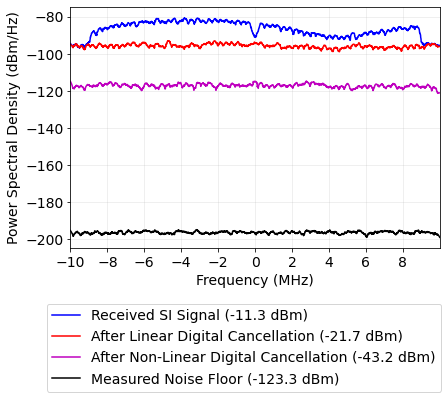


The linear SI cancellation is: 10.35 dB
The non-linear SI cancellation is: 21.49 dB
The noise floor is: -123.34 dBm
The distance from noise floor is: 80.14 dB


In [9]:
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 14}

mpl.rc('font', **font)


# Calculate various signal powers
noisePower = 10*np.log10(np.mean(np.abs(noise)**2))
scalingConst = PSD_SCALING_CONST#np.power(10,-(measuredNoisePower-noisePower)/10)

if not LIN_PREPROCESSING:
    y_test_lin = 0*y_test_orig

# Plot PSD and get signal powers
fig, noisePower, yTestPower, yTestLinCancPower, yTestNonLinCancPower = fd.plotPSD(
                                                                                y_test_orig[CHANNEL_LEN-1:]/np.sqrt(scalingConst), 
                                                                                y_test_lin[CHANNEL_LEN-1:]/np.sqrt(scalingConst), 
                                                                                y_test_pred/np.sqrt(scalingConst), 
                                                                                noise/np.sqrt(scalingConst), 
                                                                                params, 
                                                                                'NN', 
                                                                                yVar,
                                                                        )

# Print cancellation performance
print('')
print('The linear SI cancellation is: {:.2f} dB'.format(yTestPower-yTestLinCancPower))
print('The non-linear SI cancellation is: {:.2f} dB'.format(yTestLinCancPower-yTestNonLinCancPower))
print('The noise floor is: {:.2f} dBm'.format(noisePower))
print('The distance from noise floor is: {:.2f} dB'.format(yTestNonLinCancPower-noisePower))


#fig.tight_layout()
#fig.savefig('/home/nknaepper/Documents/fdnn_balatsoukas/figures/comparison/data_bal_method_bal.eps',format='eps', bbox_inches='tight')




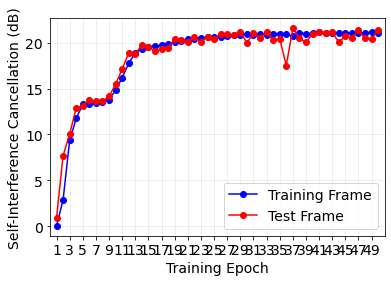

In [10]:

# Plot learning curve
plt.plot(np.arange(1,len(history.history['loss'])+1), -10*np.log10(history.history['loss']), 'bo-')
plt.plot(np.arange(1,len(history.history['loss'])+1), -10*np.log10(history.history['val_loss']), 'ro-')
plt.ylabel('Self-Interference Cancellation (dB)')
plt.xlabel('Training Epoch')
plt.legend(['Training Frame', 'Test Frame'], loc='lower right')
plt.grid(which='major', alpha=0.25)
plt.xlim([ 0, nEpochs+1 ])
plt.xticks(range(1,nEpochs,2))
#plt.savefig('figures/NNconv.pdf', bbox_inches='tight')
plt.show()

### Export Results

In [12]:
if EXPORT_RESULTS:
    file_name = PATH_EXPORT_RESULTS + 'data_' + DATA_TYPE + '_model_FFNN_linSIC_' + ('yes' if LIN_PREPROCESSING else 'no') + '.pkl'
    confirm = input(f'Export as {file_name}? (yes/no)')
    if confirm == 'yes':
        with open(file_name, 'wb') as f:
            pickle.dump({'y_test': y_test_orig[CHANNEL_LEN-1:], 'y_test_lin': y_test_lin[CHANNEL_LEN-1:], 'y_test_nl': y_test_pred, 'noise': noise, 'yVar': yVar, 'chanLen': params['hSILen']}, f)
        print('File saved.')
    else:
        print('File not saved.')

File saved.
